# How does light reflect on the lakes of Copenhagen?

Here we examine this question using Ray-Tracing!

The source term contains the details (documentation in progress), here are some results.

In [1]:
from src import *

We define first a lake. The units of the problem are meters. We define a noise_level (how wavy is the water), and a wind_level (how tall are the waves). 
If the results don't look good, decrease the stepsize. 

Then, we define a source. So far only a uniform and a Gaussian source have been implemented, but this can easily be expanded. 

Then we define a screen. This would be our eyes, standing somewhat far away from the lake and at a given height. It is important to put y_fake < 0 (the position of the "fake" screen where we project the brightness of the reflected rays). 

The plot method of the screen object shows a nice plot: black for the screen, blue for the lake. Feel free to play around this. 

Updating screen...


100%|██████████| 1001/1001 [01:00<00:00, 16.65it/s]


Plotting ...


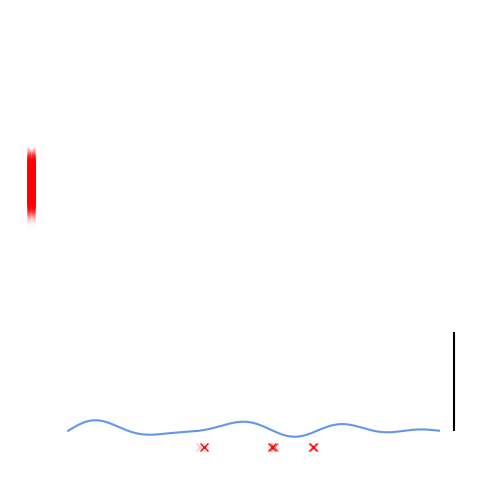

In [2]:
l = Lake(L = 50, noise_level = 7, wind_level=0.2, stepsize=0.05)
s = Source(x0 = -5, height = 15, size = 1, brightness_type='gaussian')
C = Screen(x0 = 52, H = 6, y_fake=-1, pixel=0.05)
C.update(l, s)
C.plot(s, l)